# Gagnarannsóknir
Sjá `README.md` til þess að keyra þetta vélrit (e. notebook).

Í þessu vélriti eru gögnini skoðuð og ýmsar tilgátur prófaðar. Hugmyndin er að prófa ýmiskonar forvinnsluaðferðir fyrir Moses hér og svo útfæra í heild í öðru vélriti.

Það er gert ráð fyrir því að öll gögn séu aðgengileg undir `/work/data`. Sjá leiðbeiningar í `README.md` um hvernig það er gert með `docker` eða `singularity`.

Safnið `corpus.py` skilgreinir föll og gagnategundir sem eru mikið nýttar hér.

In [212]:
from collections import defaultdict, Counter, OrderedDict
import os
import pathlib
from pathlib import Path
import re
from pprint import pprint
import importlib
from typing import List, Sequence

import matplotlib.pyplot as plt
import numpy as np

import corpus.corpus as c

importlib.reload(c)

%matplotlib notebook
print(os.getenv('MOSESDECODER'))
print(os.getenv('MOSESDECODER_TOOLS'))
print(int(os.getenv('THREADS')))
!ls {data_dir}

[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/moses
/opt/moses_tools
15
bin  en-monolingual.zip  parice  risamalheild


In [213]:
working_dir = pathlib.Path('/work')
data_dir = working_dir.joinpath('data')
processing_dir = working_dir.joinpath('process')
p = processing_dir
parice_dir = data_dir.joinpath('parice')
rmh_dir = data_dir.joinpath('risamalheild')

IS = c.Lang.IS
EN = c.Lang.EN

RMH, PARICE = 'rmh', 'parice'
TRAIN, VAL, TEST = 'train', 'val', 'test'

langs = [IS, EN]
splits = [TRAIN, VAL, TEST]

CAT = 'cat'
SHUFFLE = 'shuffle'
REGEXP = 'regexp'
SENT_FIX = 'sent_fix'
LOWER = 'lower'
TOKENIZE = 'tok'
PLACEHOLDERS = 'placeholders'
LENGTH = 'length'
DROP = 'drop'
LM = 'lm-blm'
KVISTUR = 'kvistur'
BPE = 'bpe'
TRAIN = 'train'
TEST = 'test'
VAL = 'val'
FINAL = 'final'

In [214]:
def print_line(line_number, corpus):
    result = !sed '{line_number}q;d' {corpus}
    return result[0]

Það er gott að taka til af og til.

In [22]:
def clean_dir(directory, stages):
    !ls {directory}
    for stage in stages:
        !rm -f {directory}/{stage}.is
        !rm -f {directory}/{stage}.en
    !ls {directory}

In [26]:
stages = ['arpa', 'lower', 'shuffle', 'tok']
clean_dir(test_parice_dir, stages)

bpe-final.en  final.en		kvistur.is  regexp.is	test.is
bpe-final.is  final.is		lower.en    shuffle.en	tok.en
bpe.en	      kvistur-final-en	lower.is    shuffle.is	tok.is
bpe.is	      kvistur-final-is	regexp.en   test.en
bpe-final.en  bpe.is	kvistur-final-en  regexp.en  test.is
bpe-final.is  final.en	kvistur-final-is  regexp.is
bpe.en	      final.is	kvistur.is	  test.en


## Einhliða málheild fyrir íslensku - RMH
Fyrir RMH lesum við öll tei-XML skjölin úr RMH1 og RMH2 og sameinum í eitt skjal. Þessi gögn eru aðgengileg á Terra undir `/data/risamalheild/`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/risamalheild/`.

In [12]:
xml_files = !find {rmh_dir} -name '*.xml' ! -name 'rmh2Hdr.xml' ! -name 'rmh1Hdr.xml'
xml_files = [Path(xml_file) for xml_file in xml_files]

In [13]:
!head {xml_files[0]}

<?xml version="1.0" encoding="utf-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
  <teiHeader>
    <fileDesc>
      <titleStmt>
        <title>
          <title type="main">E-576/2007</title>
        </title>
        <respStmt>
          <resp xml:lang="is">Söfnun og úrvinnsla texta</resp>


In [ ]:
rmh_txt = processing_dir.joinpath('rmh.is')
c.tei_read(xml_files, rmh_txt)

  0%|          | 5957/4152478 [00:11<3:44:06, 308.38it/s]

In [40]:
pprint(c.corpus_info_formatted(c.read(p, IS, RMH)))
print(*c.peek(c.read(p, IS, RMH)))

'/work/process/rmh.is                        8.0GiB       71254693'
Lykilorð: Skuldamál
 D Ó M U R Héraðsdóms Reykjavíkur 22. janúar 2008 í máli nr. E-576/ 2007: Seabait Co IS
 ( Einar Hugi Bjarnason hdl.)
 gegn Dímoni beitu ehf.
 ( Jón Ögmundsson hdl.) Mál þetta, sem dómtekið var að loknum munnlegum málflutningi 10. janúar sl., er höfðað með stefnu, birtri 22. janúar 2007.
 Stefnandi er Seabait Co.
 I/ S, Trafikhavnskaj 19, Esbjerg, Danmörku, en stefndi er Dímon beita ehf., Tunguhálsi 8, Reykjavík.
 Endanlegar dómkröfur stefnanda eru þær að stefndi verði dæmdur til greiðslu skuldar að fjárhæð USD 736.357,39( sic) auk 1,5% dráttarvaxta á mánuði af USD 8.473,80 frá 17. nóvember 2005 til 15. júní 2006, en af USD 736.357,84 frá þeim degi til greiðsludags, allt að frádregnum kreditreikningum að fjárhæð USD 2.680,95, dags.
 17. nóvember 2005, og að fjárhæð USD 485.955,10, dags.
 11. september 2006, sem dragast frá skuldinni miðað við stöðu hennar á útgáfudegi kreditreikninga.



### Laga setningabrot
Þar sem RMH brýtur upp setningar eftir IceNLP tilreiðaranum þá er ekki athugað hvort eftir punkti komi stór stafur. Við reynum að lagfæra þetta. Við sameinum línur sem enda á "." og fyrsti stafurinn í næstu línu er lágstafur. Þetta nær ekki yfir öll tilfelli - eins og sést í dæminu ("Sjálfstfl." ætti ekki að byrja á nýrri línu).

Þar sem útfærslan á `corpus_regepx` keyrir á hverri línu fyrir sig og við þurfum að eiga við nýjar línur þá þurfum við gera þetta skref sjálf og það er ómögulegt að keyra þessa vinnslu á mörgum þráðum án **mikillar** vinnu.

In [42]:
# The expression could be extended to cover all unicode lowercase characters using the "regex" module and [\p{Ll}]
with c.read(p, IS, RMH).open() as f_in, c.write(p, IS, RMH, SENT_FIX).open('w+') as f_out:
    f_out.write(re.sub(c.REGEXP_SUB['IS-COMBINE-NEWLINE'][0], c.REGEXP_SUB['IS-COMBINE-NEWLINE'][1], f_in.read()))

In [43]:
pprint(c.corpus_info_formatted(c.read(p, IS, RMH, SENT_FIX)))
print(*c.peek(c.read(p, IS, RMH, SENT_FIX)))

'/work/process/rmh-sent_fix.is               8.0GiB       67751145'
Lykilorð: Skuldamál
 D Ó M U R Héraðsdóms Reykjavíkur 22. janúar 2008 í máli nr. E-576/ 2007: Seabait Co IS
 ( Einar Hugi Bjarnason hdl.)
 gegn Dímoni beitu ehf.
 ( Jón Ögmundsson hdl.) Mál þetta, sem dómtekið var að loknum munnlegum málflutningi 10. janúar sl., er höfðað með stefnu, birtri 22. janúar 2007.
 Stefnandi er Seabait Co.
 I/ S, Trafikhavnskaj 19, Esbjerg, Danmörku, en stefndi er Dímon beita ehf., Tunguhálsi 8, Reykjavík.
 Endanlegar dómkröfur stefnanda eru þær að stefndi verði dæmdur til greiðslu skuldar að fjárhæð USD 736.357,39( sic) auk 1,5% dráttarvaxta á mánuði af USD 8.473,80 frá 17. nóvember 2005 til 15. júní 2006, en af USD 736.357,84 frá þeim degi til greiðsludags, allt að frádregnum kreditreikningum að fjárhæð USD 2.680,95, dags.
 17. nóvember 2005, og að fjárhæð USD 485.955,10, dags.
 11. september 2006, sem dragast frá skuldinni miðað við stöðu hennar á útgáfudegi kreditreikninga.



In [46]:
(71254693-67751145)/71254693

0.049169364886604734

## Samhliðamálheild fyrir ensku og íslensku - ParIce
Hér er unnið með ParIce málheildina. Þessar skrár er t.d. á Terra undir `/data/parice/*.tmx` eða `/scratch/smt/data/parice/*.tmx`. Í kóðanum er gert ráð fyrir að þær séu aðgengilegar undir `/work/data/parice/*.tmx`. Fyrst þarf þó aðeins að lagfæra skrárnar svo þær séu allar með sama tungumála merki.

In [47]:
!grep -m 2 "lang=\"is\"" {parice_dir}/*.tmx
!grep -m 2 "lang=\"en\"" {parice_dir}/*.tmx

/work/data/parice/ema.tmx:  <header adminlang="EN-US" creationdate="20170426T083707Z" creationtool="Moses-to-TMX-converer" creationtoolversion="1.0" datatype="plaintext" o-tmf="Moses plain text files" segtype="sentence" srclang="en">
/work/data/parice/hagstofan.tmx:  <header adminlang="en" creationdate="20170319T213035Z" creationtool="mALIGNa" creationtoolversion="2" datatype="plaintext" o-tmf="al" segtype="block" srclang="en">


In [ ]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {parice_dir}/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {parice_dir}/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {parice_dir}/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {parice_dir}/ema.tmx

In [ ]:
!grep -m 2 "lang=\"is\"" {parice_dir}/*.tmx
!grep -m 2 "lang=\"en\"" {parice_dir}/*.tmx

In [48]:
tmx_files = !ls {parice_dir}/*.tmx
tmx_files = [Path(tmx_file) for tmx_file in tmx_files]
pprint(tmx_files)

[PosixPath('/work/data/parice/baekur.tmx'),
 PosixPath('/work/data/parice/biblian.tmx'),
 PosixPath('/work/data/parice/ees.tmx'),
 PosixPath('/work/data/parice/ema.tmx'),
 PosixPath('/work/data/parice/eso.tmx'),
 PosixPath('/work/data/parice/fornritin.tmx'),
 PosixPath('/work/data/parice/hagstofan.tmx'),
 PosixPath('/work/data/parice/kde4.tmx'),
 PosixPath('/work/data/parice/opensubtitles.tmx'),
 PosixPath('/work/data/parice/tatoeba.tmx'),
 PosixPath('/work/data/parice/ubuntu.tmx')]


In [49]:
parice_tmx = c.tmx_split(tmx_files, 'EN-GB', 'IS-IS')
en_parice, is_parice = zip(*parice_tmx)

In [51]:
for corpus in en_parice + is_parice:
    pprint(c.corpus_info_formatted(corpus))

'/work/data/parice/baekur.en                1007.5KiB        12416'
'/work/data/parice/biblian.en                4.2MiB          65241'
'/work/data/parice/ees.en                   162.8MiB       1701172'
'/work/data/parice/ema.en                    39.1MiB        404333'
'/work/data/parice/eso.en                    1.7MiB          12633'
'/work/data/parice/fornritin.en              1.6MiB          17597'
'/work/data/parice/hagstofan.en             209.8KiB          2288'
'/work/data/parice/kde4.en                   1.6MiB          49912'
'/work/data/parice/opensubtitles.en          38.5MiB       1261398'
'/work/data/parice/tatoeba.en               287.6KiB          8263'
'/work/data/parice/ubuntu.en                248.1KiB         10572'
'/work/data/parice/baekur.is                 1.2MiB          12416'
'/work/data/parice/biblian.is                4.2MiB          65241'
'/work/data/parice/ees.is                   171.5MiB       1701172'
'/work/data/parice/ema.is                    42.

Sameinum ParIce gögnin fyrir hvert mál.

In [52]:
c.combine(en_parice, c.write(p, EN, PARICE))
c.combine(is_parice, c.write(p, IS, PARICE))

True

In [57]:
for lang in langs:
    pprint(c.corpus_info_formatted(c.read(p, lang, PARICE)))

'/work/process/parice.is                    265.8MiB       3545825'
'/work/process/parice.en                    251.3MiB       3545825'


### Laga setningabrot
Á nokkrum stöðum í ParIce textanum vantar bil á eftir punkti og tilreiðirinn nær ekki að brjóta þær setningar. Samsvarandi setningar í ensku eiga líka við þetta vandamál, en í minna mælli. Við reynum að vera íhaldsöm og setjum bara bil á milli þegar hástafur kemur eftir punkt á undan tveimur stöfum.

Dæmi:

In [54]:
expression = '[^|[:blank:]|[:alpha:]]{2,}\.[[:alpha:]]{1,}'
!grep -n -i -m 2 -E 'viðauka.skipunar' {c.read(p, IS, PARICE)}

82213:Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka.Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


In [56]:
regexps = [
    c.REGEXP_SUB['IS-SPLIT-NEWLINE']
]

for lang in langs:
    c.regexp(c.read(p, lang, PARICE), c.write(p, lang, PARICE, SENT_FIX), regexps=regexps)

100%|██████████| 3545825/3545825 [00:06<00:00, 578785.03it/s] 


Okkur tókst að laga þessa tilteknu setningu. Sjá `test_corpus.py` fyrir nánari prófanir.

In [58]:
print_line(82213, c.read(p, IS, PARICE, SENT_FIX))

'Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka. Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).'

### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [60]:
# the corpus_shuffle reads some bytes from the seed file and uses as a seed.
seed_file = c.read(p, EN, PARICE, SENT_FIX)
for lang in langs:
    c.shuffle(c.read(p, lang, PARICE, SENT_FIX), c.write(p, lang, PARICE, SHUFFLE), seed_file)

In [61]:
print(*c.corpora_peek([c.read(p, lang, PARICE, SHUFFLE) for lang in langs], length=3))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;
 is: Rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg.
 en: Repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys, with strong evidence for reversibility of the effect.



### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við höfum 2000 setningar í val og 3000 setningar í test.

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [63]:
for lang in langs:
    c.split(c.read(p, lang, PARICE, SHUFFLE),
            c.write(p, lang, PARICE, TRAIN),
            c.write(p, lang, PARICE, 'tmp'),
            5000)
    c.split(c.read(p, lang, PARICE, 'tmp'),
            c.write(p, lang, PARICE, TEST),
            c.write(p, lang, PARICE, VAL),
            2000)
    !rm {c.read(p, lang, PARICE, 'tmp')}

In [65]:
print(*c.corpora_peek([c.read(p, lang, PARICE, TRAIN) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, VAL) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, TEST) for lang in langs], length=2))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;

is: með hliðsjón af stofnsáttmála Evrópubandalagsins,
 en: Having regard to the Treaty establishing the European Community,
 is: Stingdu nálinni inn í hettuglasið, snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið.
 en: Insert the needle into the vial, turn the vial upside down and inject the air into the vial.

is: • 6 km fyrir bifhjól í flokki 2 (slagrými hreyfils ≥ 150 cc, Vmax < 130 km/klst.),
 en: • 6 km for Category 2 motorcycle (Engine capacity ≥ 150 cc, Vmax < 130 km/h),
 is

### Setja öll orð í lágstafi og samhæfa unicode
Hér setjum við öll tákn í lágstafi og samhæfum unicode gildi stafa sem gætu notað fleiri en eina táknun.

Það er mjög vafasamt að setja öll tákn í lágstafi og það mun búa til tvíræðni í texta, sbr. "Ég er í Símanum" og "Ég er í símanum". Hástafir í byrjun orðs er ekki mikið vandamál og auðveldlega hægt að laga í eftirvinnslu þýðinga. Hástafir í nöfnum (e. named entities) væri hægt að vinna betur með aðkomu nafnaþekkjara (e. named-entity recognizer). Við komum því aftur að þessu vandamáli síðar.

In [72]:
for lang in langs:
    for split in splits:
        c.lowercase_normalize(c.read(p, lang, PARICE, split),
                              c.write(p, lang, PARICE, split, LOWER))
c.lowercase_normalize(c.read(p, IS, RMH, SENT_FIX),
                      c.write(p, IS, RMH, LOWER))

100%|██████████| 3000/3000 [00:00<00:00, 132047.22it/s]


In [73]:
print(*c.peek(c.read(p, IS, RMH, LOWER), length=3))
print(*c.corpora_peek([c.read(p, lang, PARICE, TRAIN, LOWER) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, VAL, LOWER) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, TEST, LOWER) for lang in langs], length=2))

lykilorð: skuldamál
 d ó m u r héraðsdóms reykjavíkur 22. janúar 2008 í máli nr. e-576/ 2007: seabait co is
 ( einar hugi bjarnason hdl.)

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: in these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;

is: með hliðsjón af stofnsáttmála evrópubandalagsins,
 en: having regard to the treaty establishing the european community,
 is: stingdu nálinni inn í hettuglasið, snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið.
 en: insert the needle into the vial, turn the vial upside down and inject the air into the vial.

is: • 6 km fyrir bifhjól í flokki 

### Fjarlægja slæm tákn
Hér fjarlægjum við vefslóðir/tölvupósta og fleira (URI) og tóma hornklofa og sviga (sem koma oft fram í gögnunum).

Hugmyndin er að búa til betra mállíkan með því að setja leppinn `@uri@` í stað strengins. Þetta hefur þær afleiðingar að fjöldi tákna í textanum fækkar umtalsvert, sem gerir þýðingar auðveldari. Þetta skref er hægt að lagfæra í eftirvinnslu þýðinga (en þarf þó betri útfærslu, ef t.d. tvær vefslóðir koma fyrir í setningu).

Við tökum þetta skref núna því við treystum ekki tilreiðurunum til þess að túlka URIs rétt. Þar sem við notuðum tilreiðara síðar meir þá þurfum við að laga leppina eftir það.

Við reynum að grípa URIs úr gögnunum. Við reynum sérstaklega að ná
- Öllu sem byrjar á http(s):// eða www
- Tölvupóstföngum anna@anna.is
- Öllu sem endar á .is eða .com

Við reynum að komast hjá því að fjarlægja punkt sem kemur á eftir URI.

Tómir hornklofar og svigar hafa enga merkingu og er í raun galli í gögnunum. Þeir eru fjarlægðir.

In [83]:
regexps = [
    c.REGEXP_SUB['URI'],
    c.REGEXP_SUB['URI-SIMPLE'],
    c.REGEXP_SUB['EMPTY-BRACKETS']
]

In [84]:
IN = LOWER
OUT = REGEXP

for lang in langs:
    for split in splits:
        c.regexp(c.read(p, lang, PARICE, split, IN),
                 c.write(p, lang, PARICE, split, OUT),
                 regexps)
c.regexp(c.read(p, IS, RMH, IN),
         c.write(p, IS, RMH, OUT),
         regexps)

100%|██████████| 67751145/67751145 [03:47<00:00, 297674.56it/s]


True

In [85]:
!grep -n "www.garn.is" -m 10 {c.read(p, IS, RMH, LOWER)}

32026172:dagatalið mun fást í bjarnabúð í biskupstungum, á sunnlenska bókakaffinu á selfossi, í búðinni á geysi og á netinu á www.garn.is.
48353784:www.garn.is sívalningur
48365714:fæst hjá handverkskúnst, www.garn.is
48369001:www.garn.is
48377689:www.garn.is
48386864:garnið í peysuna verður á tilboði í fjarðarkaupum og á www.garn.is í október.
48389870:efni: sport garn svart og hvítt fæst á www.garn.is og í bjarkarhóli á nýbýlavegi.
48392253:efni: filatura zara til í mörgum fleiri litum líka má prjóna flíkina úr basak garninu sem fæst í mörgum litum sjá www.garn.is fæst í fjarðarkaupum og bjarkahóli nýbýlavegi 32 kópavogi.
48392768:sjá www.garn.is
48394973:sjá útsölustaði á www.garn.is.


In [89]:
print_line(2970, c.read(p, IS, PARICE, TRAIN, LOWER))

'info@fatroiberica.es tel: + 34-(0)93-473 55 44 info@fatroiberica.es'

In [90]:
!grep -n -m 3 @uri@ {c.read(p, IS, PARICE, TRAIN, REGEXP)}

72:ítarlegar upplýsingar um lyfið eru birtar á vef lyfjastofnunar evrópu @uri@
2970:@uri@ tel: + 34-(0)93-473 55 44 @uri@
3585:frekari upplýsingar um hvernig gildandi kerfi og hnattsamræmda kerfið (hsk) skarast má finna í vii. viðauka í iii. bindi tillögunnar sem var samþykkt: @uri@


### Tilreiðir
Núna tilreiðum við gögnin.

In [215]:
IN = REGEXP
OUT = TOKENIZE
methods = {
    IS: 'pass-through',
    EN: 'moses'
}

for lang in langs:
    for split in splits:
        c.tokenize(c.read(p, lang, PARICE, split, IN),
                   c.write(p, lang, PARICE, split, OUT, methods[lang]),
                   method=methods[lang])
c.tokenize(c.read(p, IS, RMH, IN),
           c.write(p, IS, RMH, OUT, methods[IS]),
           method=methods[IS])

100%|██████████| 67751145/67751145 [27:38<00:00, 40839.57it/s]  


True

In [191]:
!grep -n -m 3 "@ uri @" {c.read(p, IS, PARICE, TRAIN, TOKENIZE)}

72:ítarlegar upplýsingar um lyfið eru birtar á vef lyfjastofnunar evrópu @ uri @
2970:@ uri @ tel : + 34- ( 0 ) 93-473 55 44 @ uri @
3585:frekari upplýsingar um hvernig gildandi kerfi og hnattsamræmda kerfið ( hsk ) skarast má finna í vii. viðauka í iii. bindi tillögunnar sem var samþykkt : @ uri @


In [217]:
pprint(c.list_dir(p, [IS, EN], PARICE, TOKENIZE))

/work/process/parice-sent_fix.en           251.3MiB       3545825
/work/process/parice-sent_fix.is           265.8MiB       3545825
/work/process/parice-shuffle.en            251.3MiB       3545825
/work/process/parice-shuffle.is            265.8MiB       3545825
/work/process/parice-test-final-moses.en   212.9KiB          3000
/work/process/parice-test-final-moses.is   224.0KiB          3000
/work/process/parice-test-lower.en         206.3KiB          3000
/work/process/parice-test-lower.is         218.3KiB          3000
/work/process/parice-test-placeholders-moses.en   212.9KiB          3000
/work/process/parice-test-placeholders-moses.is   224.0KiB          3000
/work/process/parice-test-placeholders.en   212.9KiB          3000
/work/process/parice-test-placeholders.is   224.0KiB          3000
/work/process/parice-test-regexp.en        206.2KiB          3000
/work/process/parice-test-regexp.is        218.2KiB          3000
/work/process/parice-test-tok-moses.en     212.5KiB         

### Laga leppi og setja fleiri
Núna þurfum við að laga leppina sem við settum í fyrra skrefi og á sama tíma setjum við leppi fyrir tákn sem Moses skilur sérstaklega.

In [218]:
regexps = [
    c.REGEXP_SUB["PIPE"],
    c.REGEXP_SUB["FIX-URI"],
    c.REGEXP_SUB["LT"],
    c.REGEXP_SUB["GT"],
    c.REGEXP_SUB["BRACKET-OPEN"],
    c.REGEXP_SUB["BRACKET-CLOSE"]
]

In [219]:
IN = TOKENIZE
OUT = PLACEHOLDERS

for lang in langs:
    for split in splits:
        c.regexp(c.read(p, lang, PARICE, split, IN, methods[lang]),
                 c.write(p, lang, PARICE, split, OUT, methods[lang]),
                 regexps)
c.regexp(c.read(p, IS, RMH, IN, methods[IS]),
         c.write(p, IS, RMH, OUT, methods[IS]),
         regexps)

100%|██████████| 67751145/67751145 [04:25<00:00, 255097.77it/s]


True

In [220]:
print(*c.peek(c.read(p, IS, RMH, PLACEHOLDERS, 'pass-through'), length=3))
print(*c.corpora_peek([c.read(p, lang, PARICE, TRAIN, PLACEHOLDERS, methods[lang]) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, VAL, PLACEHOLDERS, methods[lang]) for lang in langs], length=2))
print(*c.corpora_peek([c.read(p, lang, PARICE, TEST, PLACEHOLDERS, methods[lang]) for lang in langs], length=2))

lykilorð : skuldamál
 d ó m u r héraðsdóms reykjavíkur 22. janúar 2008 í máli númer e - 576 / 2007 : seabait co is
 ( einar hugi bjarnason héraðsdómslögmaður )

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma .
 en: in these cases , smaller bilge wells to cover a reasonable period of time may be permitted .
 is: • hættuflokka 3.1 til 3.6 , 3.7 , skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun , 3.8 , áhrif önnur en sljóleiki , 3.9 og 3.10 ,
 en: • hazard classes 3.1 to 3.6 , 3.7 adverse effects on sexual function and fertility or on development , 3.8 effects other than narcotic effects , 3.9 and 3.10 ;

is: með hliðsjón af stofnsáttmála evrópubandalagsins ,
 en: having regard to the treaty establishing the european community ,
 is: stingdu nálinni inn í hettuglasið , snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið .
 en: insert the needle into the vial , turn the vial upside down and inject the air into the v

### Skoða tölfræði
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [221]:
en_sent_counter = c.sentence_counter(c.read(p, EN, PARICE, TRAIN, PLACEHOLDERS, 'moses'))
is_sent_counter = c.sentence_counter(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'pass-through'))

In [222]:
def draw_bar_plot(title, counter):
    if isinstance(counter, Counter):
        labels, values = zip(*sorted(counter.items()))
    else:
        labels, values = zip(*sorted(counter))
    indexes = np.arange(len(labels))
    step = 10
    width = 1
    cumulative_sum = np.cumsum(values)/np.sum(values)
    
    fig, ax1 = plt.subplots(figsize=(9,9))
    color='tab:red'
    ax1.set_xlabel('Sentence length')
    ax1.set_ylabel('#Sentences', color=color)
    ax1.set_title(title)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.bar(indexes, values, width, color=color)
    ax1.set_xticks(indexes[0::step])
    ax1.set_xticklabels(labels[0::step])
    ax1.grid(linestyle='--', linewidth=1)
    
    ax2 = ax1.twinx()
    color='tab:blue'
    ax2.set_ylabel('Coverage fraction', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(indexes, cumulative_sum, width, color=color)
    plt.show()

<IPython.core.display.Javascript object>


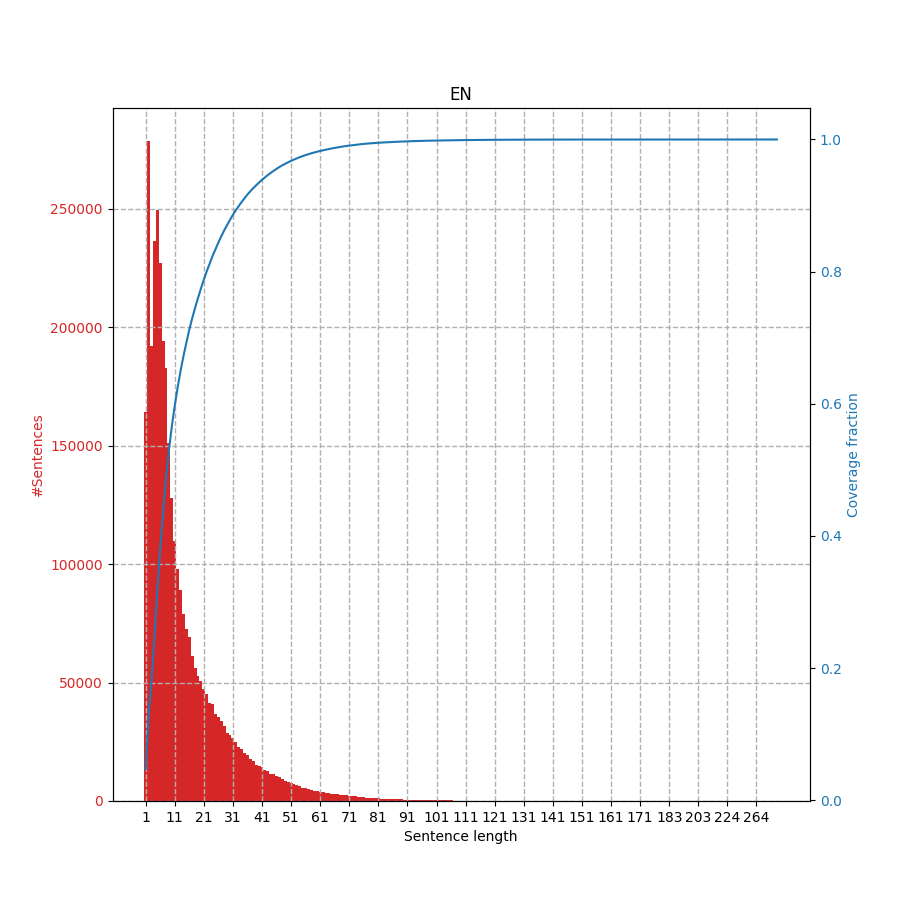

In [223]:
draw_bar_plot("EN", en_sent_counter)

<IPython.core.display.Javascript object>


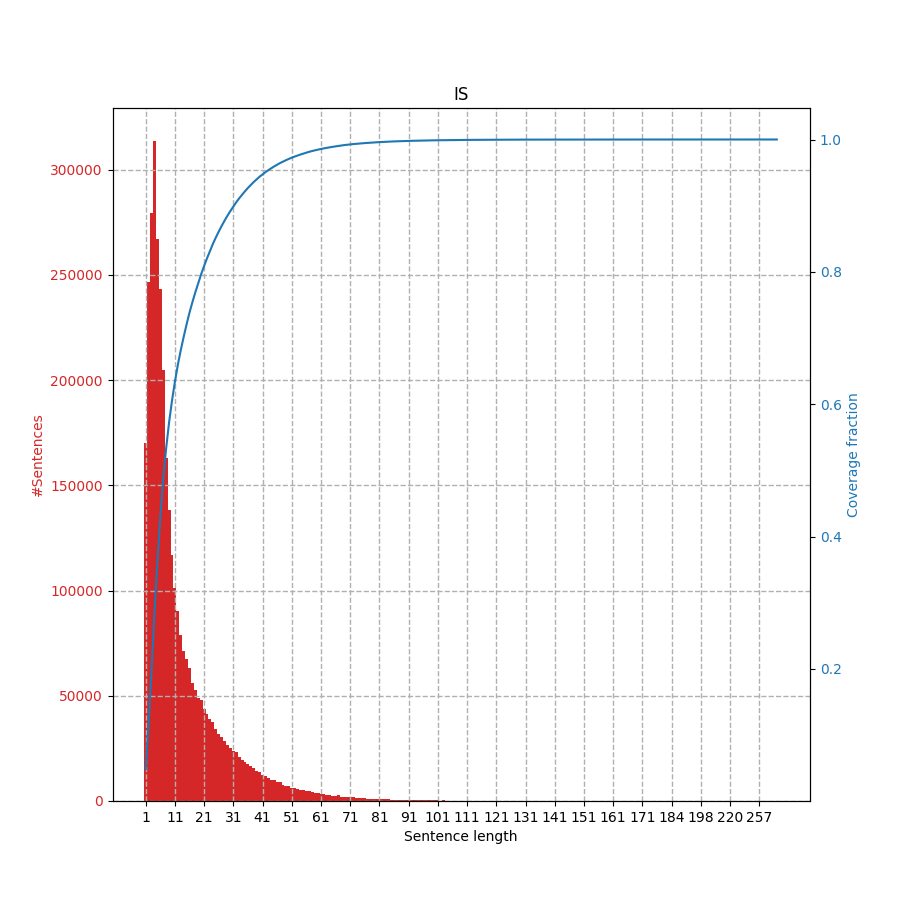

In [224]:
draw_bar_plot("IS", is_sent_counter)

In [225]:
rmh_sent_counter = c.sentence_counter(c.read(p, IS, RMH, PLACEHOLDERS, 'pass-through'))

Það eru margar setningar sem eru fáránlega langar. Sleppum þeim til að fá betri mynd.

<IPython.core.display.Javascript object>


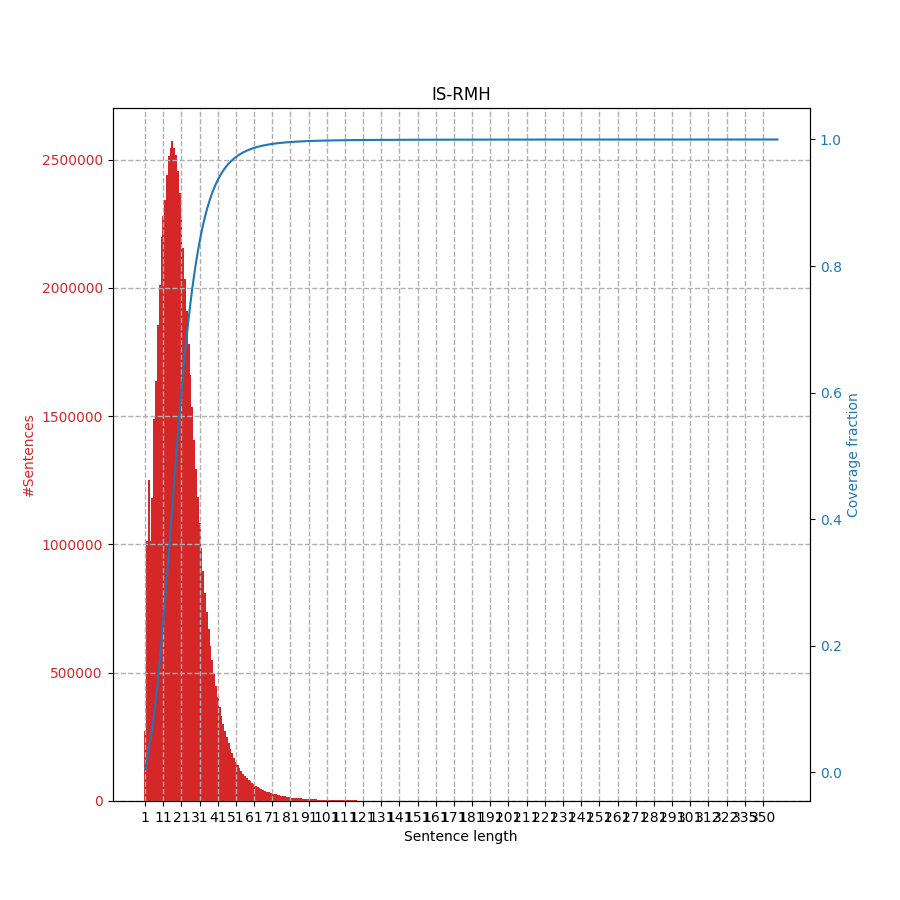

In [226]:
draw_bar_plot("IS-RMH", rmh_sent_counter.most_common()[:-1000])

### Fjöldi tákna og tíðni

In [227]:
is_counter = c.token_counter(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'pass-through'))
en_counter = c.token_counter(c.read(p, EN, PARICE, TRAIN, PLACEHOLDERS, 'moses'))
rmh_counter = c.token_counter(c.read(p, IS, RMH, PLACEHOLDERS, 'pass-through'))

Fjöldi mismunandi orða.

In [194]:
pprint(len(en_counter))
pprint(len(is_counter))
pprint(len(rmh_counter))

321245
737743
6478644


In [228]:
pprint(len(en_counter))
pprint(len(is_counter))
pprint(len(rmh_counter))

321245
630063
5620342


In [148]:
import random
pprint(random.sample(rmh_counter.most_common(), 30))

[('brucekaupir', 1),
 ('tengdasonunum', 49),
 ('undirstöðuáfanga', 2),
 ('tökudrengur', 4),
 ('14.309', 2),
 ('pyk', 3),
 ('kjúklingaballentínan', 1),
 ('goffrado', 2),
 ('6600194', 1),
 ('52501', 1),
 ('culicaides', 1),
 ('misstan', 4),
 ('matmælaverð', 1),
 ('33.866', 2),
 ('deadman', 8),
 ('pittí', 1),
 ('kevindebrunye', 1),
 ('eiðslunni', 1),
 ('þinglesin', 308),
 ('rsagði', 1),
 ('lágmarkstækjaeign', 1),
 ('nærinnrauð', 2),
 ('kómet', 1),
 ('auðvaldsklíka', 1),
 ('loftfimleikamann', 5),
 ('knúk', 1),
 ('181.142', 1),
 ('oprandi', 2),
 ('lífsannar', 1),
 ('gelneglur', 30)]


Fjöldi orða.

In [195]:
pprint(f"{'Ensk orð: ':<20}{sum(value for key, value in en_counter.items()):>15}")
pprint(f"{'Íslensk orð: ':<20}{sum(value for key, value in is_counter.items()):>15}")
pprint(f"{'Íslensk orð (RMH): ':<20}{sum(value for key, value in rmh_counter.items()):>15}")

'Ensk orð:                  50423571'
'Íslensk orð:               45584704'
'Íslensk orð (RMH):       1398568722'


## Fjarlægja slæmar línur
Núna búum við til safn af "íslenskum" orðum frá RMH og förum yfir íslenskar setningar í ParIce og athugum hversu stórt hlutfall af orðunum í ParIce-IS eru í safninu okkar.

In [229]:
is_words = set(rmh_counter.keys())
len(is_words)

5620342

In [230]:
# Setting the chunksize higher is better here.
print(c.CHUNKSIZE)
c.CHUNKSIZE = 50000
print(c.CHUNKSIZE)

4000
50000


In [231]:
skip_lines = c.get_skip_lines(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'moses'),
                              [c.REGEXP_SUB['CRYLLIC'][0],
                               c.REGEXP_SUB['GREEK'][0],
                               c.REGEXP_SUB['UNKNOWN-CHARS'][0]
                              ],
                              is_words,
                              keep_ratio=0.7,
                              normalize=True,
                              keep_sent_length=1)


100%|██████████| 3540825/3540825 [03:29<00:00, 16886.94it/s]


In [232]:
lines = [number for number, fraction, line in skip_lines]
print("new fraction", (1 - (c.corpus_info(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'moses'))[2] - len(lines))/c.corpus_info(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'moses'))[2]))

new fraction 0.05357056618161027


fraction removed: 0.0451

In [233]:
pprint(skip_lines[:50])

[(39, 0.5, 'hycamtin 0,25 mg\n'),
 (49, 0.6666666666666666, 'venjulegur rannsóknarstofubúna ur\n'),
 (53, 0.0, 'eph.6.13\n'),
 (64, 0.6666666666666666, 'þvagræsilyf ( t.d. fúrósemíð , búmetaníð )\n'),
 (81, 0.0, 'eph.6.23\n'),
 (90, 0.3333333333333333, 'rafstöðuskilja eða pokasía\n'),
 (93, 0.0, '2. gr.\n'),
 (97, 0.0, 'lev.27.5\n'),
 (133, 0.6666666666666666, '2. hönnun á prófunarfleti\n'),
 (151, 0.5, '• tengingarbundið gaumljós\n'),
 (174, 0.0, '9. gr.\n'),
 (194,
  0.0,
  '• u-gildi óþynnts útblásturslofts á grundvelli eiginleika kjörgass við λ = '
  '2 , þurrt loft , 273 k , 101,3 kpa\n'),
 (197, 0.0, 'phi.2.27\n'),
 (210, 0.0, 'c24 0,98 ( 0,93 ; 1,03 )\n'),
 (249, 0.0, '7. gr.\n'),
 (255, 0.0, '10. gr.\n'),
 (268, 0.0, '• charente-vatnasvæðið ,\n'),
 (280, 0.0, '\uf0ad 1,29 ( 0.98-1,68 ) .\n'),
 (281, 0.0, 'gen.12.7\n'),
 (289, 0.0, '• bodc p01 stikanotkun ( bodc _ p01parameterusagevalue ) :\n'),
 (296,
  0.5,
  'metakrýlsýru-etýlakrýlat samfjölliða ( 1 : 1 ) natríumlárýlsúlfat\n

In [236]:
# дейност, είδοσ, εγκατάστασησ, казеин, приложение, ž č š лицата, 12052
print(c.sent_contains_regexp(print_line(13381, c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'pass-through')), c.REGEXP_SUB['CRYLLIC'][0]))

True


In [283]:
def hex_values(sentence):
    for c in sentence:
        print(hex(ord(c)))

0x2022


In [199]:
!grep -n "Георги" {c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'moses')}

In [237]:
if 2935276 in lines:
    print("gone")

gone


Núna hendum við þessum slæmu línum úr þjálfunargögnunum.

In [238]:
pprint(c.corpus_info_formatted(c.read(p, IS, PARICE, TRAIN, PLACEHOLDERS, 'pass-through')))

('/work/process/parice-train-placeholders-pass-through.is   275.0MiB       '
 '3540825')


In [239]:
IN = PLACEHOLDERS
OUT = DROP

for lang in langs:
    c.skip_lines(c.read(p, lang, PARICE, TRAIN, IN, methods[lang]),
                 c.write(p, lang, PARICE, TRAIN, OUT, methods[lang]),
                 lines_in=lines)

In [240]:
pprint(c.corpus_info_formatted(c.read(p, IS, PARICE, TRAIN, DROP, methods[IS])))

'/work/process/parice-train-drop-pass-through.is   268.2MiB       3351141'


In [241]:
print(*c.corpora_peek([c.read(p, lang, PARICE, TRAIN, PLACEHOLDERS, methods[lang]) for lang in langs], length=6))

is: í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma .
 en: in these cases , smaller bilge wells to cover a reasonable period of time may be permitted .
 is: • hættuflokka 3.1 til 3.6 , 3.7 , skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun , 3.8 , áhrif önnur en sljóleiki , 3.9 og 3.10 ,
 en: • hazard classes 3.1 to 3.6 , 3.7 adverse effects on sexual function and fertility or on development , 3.8 effects other than narcotic effects , 3.9 and 3.10 ;
 is: rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg .
 en: repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys , with strong evidence for reversibility of the effect .
 is: samtímismeðferð með meðalmiklum cyp 3 a 4 hemlum ( til dæmis dílítazem , verapamíl , klarítrómýcín , etýtrómýcín , aprepítant , amíódarón ) skal aðeins gefin m

### Skrifa sem endanleg skjöl
Til þess að samhæfa á móti þjálfun þá afritum við gögnin úr síðasta skrefið og endurnefnum.

In [243]:
OUT = FINAL

!cp {c.read(p, IS, PARICE, TRAIN, DROP, 'pass-through')} {c.write(p, IS, PARICE, TRAIN, OUT)}
!cp {c.read(p, EN, PARICE, TRAIN, DROP, 'moses')} {c.write(p, EN, PARICE, TRAIN, OUT)}
!cp {c.read(p, IS, PARICE, VAL, PLACEHOLDERS, 'pass-through')} {c.write(p, IS, PARICE, VAL, OUT)}
!cp {c.read(p, EN, PARICE, VAL, PLACEHOLDERS, 'moses')} {c.write(p, EN, PARICE, VAL, OUT)}
!cp {c.read(p, IS, PARICE, TEST, PLACEHOLDERS, 'pass-through')} {c.write(p, IS, PARICE, TEST, OUT)}
!cp {c.read(p, EN, PARICE, TEST, PLACEHOLDERS, 'moses')} {c.write(p, EN, PARICE, TEST, OUT)}
!cp {c.read(p, IS, RMH, PLACEHOLDERS, 'pass-through')} {c.write(p, IS, RMH, OUT)}

### Keyra Kvist
Núna keyrum við Kvist á íslensku hlið gagnanna. Þetta er gert til þess að fækkja fjölda óþekktra orða og vonandi auðvelda þýðingar. Við þurfum að gera þessa vinnslu á `train`, `test` og `val`. Til þess að geta keyrt Kvist, þarf forritið (`kvistur.py`) að vera aðgengilegt í núverandi skrá með nauðsynlegum gögnum (`resources`). Kvist er ekki deilt með þessu kerfi.

Áður en Kvistur er keyrður erum við með eftirfarandi fjölda íslenskra orða, samtals.
- 'Íslensk orð:               46.731.475'
- 'Íslensk orð (RMH):       1.414.383.094'

Og fjöldi ólíkra orða:
- 630.448
- 5.621.932

Við búumst við að fyrri tölurnar hækki og seinni tölurnar lækki.

In [5]:
import kvistur
import os

resources = {
    "modifiers": os.path.join('resources', 'modifiers.dawg'),
    "heads": os.path.join('resources', 'heads.dawg'),
    "templates": os.path.join('resources', 'templates.dawg'),
    "splits": os.path.join('resources', 'splits.dawg')
}
kv = kvistur.Kvistur(**resources)
words = ["sveitarstjórnarkosningarnar", "kosningarnar", "landbúnaðarframleiðslunnar"]
for word in words:
    score, tree = kv.decompound(word)
    print(word)
    print(tree.get_atoms())
    print(tree.get_binary_split())
    print(tree.get_tree())
    print()


sveitarstjórnarkosningarnar
['sveitar', 'stjórnar', 'kosningarnar']
('sveitarstjórnar', 'kosningarnar')
(('sveitar', 'stjórnar'), 'kosningarnar')

kosningarnar
['kosningarnar']
None
kosningarnar

landbúnaðarframleiðslunnar
['land', 'búnaðar', 'fram', 'leiðslunnar']
('landbúnaðar', 'framleiðslunnar')
(('land', 'búnaðar'), ('fram', 'leiðslunnar'))



In [6]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from functools import partial

def sent_kvistur(sentence: str, method='binary'):
    """ Apply Kvistur to a given sentence. Returns the decomposed sentence.
    method='atoms' will decompond the word as much as possible.
    method=(default)'binary' will decompose the word to at most two parts.
    """
    result = []
    # we leave the \n
    words = sentence.split(" ")
    for word in words:
        score, tree = kv.decompound(word)
        if method == 'atoms':
            result.extend(tree.get_atoms())
        else:
            if tree.get_binary_split():
                result.extend(tree.get_binary_split())
            else:
                result.append(word)
    return " ".join(result)

def corpus_kvistur(path, out_path, method='binary'):
    with ProcessPoolExecutor(max_workers=c.THREADS) as executor:
        with path.open() as f_in, out_path.open('w+') as f_out:
            f_list = f_in.readlines()
            results = tqdm(executor.map(
                partial(sent_kvistur, method=method),
                f_list,
                chunksize=5000),
                total=len(f_list))
            for line in results:
                f_out.write(line)

In [7]:
is_train[KVISTUR] = c.corpus_create_path(is_train[FINAL], KVISTUR)
is_val[KVISTUR] = c.corpus_create_path(is_val[FINAL], KVISTUR)
is_test[KVISTUR] = c.corpus_create_path(is_test[FINAL], KVISTUR)
rmh[KVISTUR] = c.corpus_create_path(rmh[FINAL], KVISTUR)

corpus_kvistur(is_train[FINAL], is_train[KVISTUR], method='atoms')
corpus_kvistur(is_val[FINAL], is_val[KVISTUR], method='atoms')
corpus_kvistur(is_test[FINAL], is_test[KVISTUR], method='atoms')
corpus_kvistur(rmh[FINAL], rmh[KVISTUR], method='atoms')

100%|██████████| 67751125/67751125 [1:54:43<00:00, 9841.90it/s]  


In [8]:
print(*c.corpus_peek(rmh[KVISTUR]))

karvel pálma son :
 herra for seti .
 það eru aðeins ör fá orð .
 fyrst í til efni af því , sem hæst virtur fjmrh . sagði og vildi ráð leggja mér vinnu brögð , þá er ég vissu lega þakk látur fyrir það .
 en heldur hefði ég kosið , að þessi ráð legging hefði komið fram fyrr í dag , þannig að ég hefði getað nýtt þann tíma , sem farið hefur í það hjá stjórnar liðinu að semja um það , sem hér á að fara fram í dag eða á morgun , hátt í 2 klukku tíma í dag , og þá hefði ég vissu lega þegið þá á bendingu að kynna mér frekar , hvað hv . þing maður .
 sjálfstfl . hefðu sagt um ýmis mál hér á undan förnum vikum eða mánuðum .
 ég heyrði það ekki í ræðu hæst virtur fjmrh . , þegar hann talaði hér á eftir már , að hann viki einu orði að því að rengja þær upp lýsingar , sem ég var hér með um stöðu ríkis sjóðs og eru skjal festar á blaði frá hans fyrir rennara , hæst virtur nú verandi samgöngu ráð herra .
 ég heyrði ekki , að hann ýjaði að því einu orði , að þær væru rangar , og ég vil ein dregið kre

In [14]:
print(*c.corpus_peek(rmh[KVISTUR]))

karvel pálma son :
 herra for seti .
 það eru aðeins ör fá orð .
 fyrst í til efni af því , sem hæst virtur fjmrh . sagði og vildi ráð leggja mér vinnu brögð , þá er ég vissu lega þakk látur fyrir það .
 en heldur hefði ég kosið , að þessi ráð legging hefði komið fram fyrr í dag , þannig að ég hefði getað nýtt þann tíma , sem farið hefur í það hjá stjórnar liðinu að semja um það , sem hér á að fara fram í dag eða á morgun , hátt í 2 klukku tíma í dag , og þá hefði ég vissu lega þegið þá á bendingu að kynna mér frekar , hvað hv . þing maður .
 sjálfstfl . hefðu sagt um ýmis mál hér á undan förnum vikum eða mánuðum .
 ég heyrði það ekki í ræðu hæst virtur fjmrh . , þegar hann talaði hér á eftir már , að hann viki einu orði að því að rengja þær upp lýsingar , sem ég var hér með um stöðu ríkis sjóðs og eru skjal festar á blaði frá hans fyrir rennara , hæst virtur nú verandi samgöngu ráðherra .
 ég heyrði ekki , að hann ýjaði að því einu orði , að þær væru rangar , og ég vil ein dregið kref

In [9]:
kvistur_counter = c.corpus_token_counter(is_train[KVISTUR])
kvistur_rmh_counter = c.corpus_token_counter(rmh[KVISTUR])

In [10]:
print(len(kvistur_counter))
print(len(kvistur_rmh_counter))
pprint(f"{'Íslensk orð (Kvistur): ':<20}{sum(value for key, value in kvistur_counter.items()):>15}")
pprint(f"{'Íslensk orð (Kvistur, RMH): ':<20}{sum(value for key, value in kvistur_rmh_counter.items()):>15}")

255578
2448589
'Íslensk orð (Kvistur):        54300700'
'Íslensk orð (Kvistur, RMH):      1682205787'


In [18]:
print(len(kvistur_counter))
print(len(kvistur_rmh_counter))

292079
2754439


In [17]:
pprint(f"{'Íslensk orð (Kvistur): ':<20}{sum(value for key, value in kvistur_counter.items()):>15}")
pprint(f"{'Íslensk orð (Kvistur, RMH): ':<20}{sum(value for key, value in kvistur_rmh_counter.items()):>15}")

'Íslensk orð (Kvistur):        52592991'
'Íslensk orð (Kvistur, RMH):      1633763707'


Svo skrifum við þessar niðurstöður sem loka niðurstöður.

In [ ]:
OUT = 'kvistur-final'

en_train[OUT] = c.corpus_create_path(en_train[DROP], OUT)
is_train[OUT] = c.corpus_create_path(is_train[KVISTUR], OUT)
en_val[OUT] = c.corpus_create_path(en_val[REGEXP], OUT)
is_val[OUT] = c.corpus_create_path(is_val[KVISTUR], OUT)
en_test[OUT] = c.corpus_create_path(en_test[REGEXP], OUT)
is_test[OUT] = c.corpus_create_path(is_test[KVISTUR], OUT)
rmh[OUT] = c.corpus_create_path(rmh[KVISTUR], OUT)

!cp {en_train[DROP]} {en_train[OUT]}
!cp {is_train[KVISTUR]} {is_train[OUT]}
!cp {en_val[REGEXP]} {en_val[OUT]}
!cp {is_val[KVISTUR]} {is_val[OUT]}
!cp {en_test[REGEXP]} {en_test[OUT]}
!cp {is_test[KVISTUR]} {is_test[OUT]}
!cp {rmh[KVISTUR]} {rmh[OUT]}

### BPE
Núna prófum við að nota BPE á textann. Fyrst prófum við að nota keyra ekki Kvist fyrst. Búum til orðasafn með 30k orðum þjálfað á þjálfunargögnunum.

In [5]:
import sentencepiece as spm

In [ ]:
spm.SentencePieceTrainer.Train(f'--input={is_train[DROP]} --model_prefix=is --vocab_size=30000 --model_type=bpe --hard_vocab_limit=false')
spm.SentencePieceTrainer.Train(f'--input={en_train[DROP]} --model_prefix=en --vocab_size=30000 --model_type=bpe --hard_vocab_limit=false')

In [14]:
!ls

LICENSE			environment.yml		moses-Dockerfile
README.md		google_translate.ipynb	moses_phrase_baseline.ipynb
__pycache__		is.model		moses_phrase_full.ipynb
corpus			is.vocab		moses_phrase_full_para.ipynb
corpus-Dockerfile	kvistur.py		resources
data_exploration.ipynb	m.model			run-jupyter.sbatch
en.model		m.vocab			server.out
en.vocab		model-Dockerfile


In [6]:
sp = spm.SentencePieceProcessor()
sp.Load("en.model")
sp.EncodeAsPieces("This is a test @uri@\n")

['▁', 'T', 'h', 'is', '▁is', '▁a', '▁test', '▁@', 'uri', '@']

In [7]:
from tqdm import tqdm

def corpus_spm(path, out_path, model):
    sp = spm.SentencePieceProcessor()
    sp.Load(model)
    with path.open() as f_in, out_path.open('w+') as f_out:
        f_list = f_in.readlines()
        for line in tqdm(f_list, total=len(f_list)):
            # sentence piece EncodeAsPieces is not picklable - so no multithreading
            f_out.write(" ".join(sp.EncodeAsPieces(line)) + "\n")

In [8]:
OUT=BPE

en_train[OUT] = c.corpus_create_path(en_train[DROP], OUT)
is_train[OUT] = c.corpus_create_path(is_train[DROP], OUT)
en_val[OUT] = c.corpus_create_path(en_val[REGEXP], OUT)
is_val[OUT] = c.corpus_create_path(is_val[REGEXP], OUT)
en_test[OUT] = c.corpus_create_path(en_test[REGEXP], OUT)
is_test[OUT] = c.corpus_create_path(is_test[REGEXP], OUT)
rmh[OUT] = c.corpus_create_path(rmh[REGEXP], OUT)

corpus_spm(en_train[DROP], en_train[OUT], 'en.model')
corpus_spm(is_train[DROP], is_train[OUT], 'is.model')
corpus_spm(en_val[REGEXP], en_val[OUT], 'en.model')
corpus_spm(is_val[REGEXP], is_val[OUT], 'is.model')
corpus_spm(en_test[REGEXP], en_test[OUT], 'en.model')
corpus_spm(is_test[REGEXP], is_test[OUT], 'is.model')
corpus_spm(rmh[REGEXP], rmh[OUT], 'is.model')

 66%|██████▌   | 44550472/67751125 [44:21<20:19, 19023.62it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 67751125/67751125 [1:05:44<00:00, 17175.42it/s]


In [10]:
print(*c.corpora_peek([en_train[BPE], is_train[BPE]]))

en: ▁in ▁these ▁cases ▁, ▁smaller ▁bilge ▁wells ▁to ▁cover ▁a ▁reasonable ▁period ▁of ▁time ▁may ▁be ▁permitted ▁.
 is: ▁í ▁slíkum ▁tilvikum ▁má ▁heimila ▁minni ▁austur sb run na ▁sem ▁geta ▁tekið ▁við ▁af renn slinu ▁á ▁hæfilega ▁löngum ▁tíma ▁.
 en: ▁• ▁hazard ▁classes ▁3.1 ▁to ▁3.6 ▁, ▁3.7 ▁adverse ▁effects ▁on ▁sexual ▁function ▁and ▁fertility ▁or ▁on ▁development ▁, ▁3.8 ▁effects ▁other ▁than ▁narcotic ▁effects ▁, ▁3.9 ▁and ▁3.10 ▁;
 is: ▁• ▁hættuf lokka ▁3.1 ▁til ▁3.6 ▁, ▁3.7 ▁, ▁skaðleg ▁áhrif ▁á ▁kyn starfsemi ▁og ▁frjósemi ▁eða ▁þroskun ▁, ▁3.8 ▁, ▁áhrif ▁önnur ▁en ▁sl jó leiki ▁, ▁3.9 ▁og ▁3.10 ▁,
 en: ▁repeated - dose ▁toxicity ▁studies ▁revealed ▁vac u olation ▁of ▁the ▁tubular ▁cells ▁of ▁the ▁kidneys ▁, ▁with ▁strong ▁evidence ▁for ▁reversibility ▁of ▁the ▁effect ▁.
 is: ▁rannsóknir ▁á ▁eiturverkunum ▁eftir ▁endurtekna ▁skammta ▁leiddu ▁í ▁ljós ▁fry mis ból um yndun ▁á ▁nýrnapíp lum ▁og ▁bentu ▁rannsóknir ▁sterk lega ▁til ▁að ▁þessi ▁áhrif ▁væru ▁afturkall anleg ▁.
 en: ▁

In [12]:
OUT = 'bpe-final'

en_train[OUT] = c.corpus_create_path(en_train[BPE], OUT)
is_train[OUT] = c.corpus_create_path(is_train[BPE], OUT)
en_val[OUT] = c.corpus_create_path(en_val[BPE], OUT)
is_val[OUT] = c.corpus_create_path(is_val[BPE], OUT)
en_test[OUT] = c.corpus_create_path(en_test[BPE], OUT)
is_test[OUT] = c.corpus_create_path(is_test[BPE], OUT)
rmh[OUT] = c.corpus_create_path(rmh[BPE], OUT)

!cp {en_train[BPE]} {en_train[OUT]}
!cp {is_train[BPE]} {is_train[OUT]}
!cp {en_val[BPE]} {en_val[OUT]}
!cp {is_val[BPE]} {is_val[OUT]}
!cp {en_test[BPE]} {en_test[OUT]}
!cp {is_test[BPE]} {is_test[OUT]}
!cp {rmh[BPE]} {rmh[OUT]}